# **Brain Tumor Classification Using VGG16 Convolution Neural Network (CNN)**
*Authors: Atahan Çaldır, Musa Berkay Kocabaşoğlu, Kerem Ersan* 

*Class: CS 454 - Introduction to Machine Learning and Artificial Neural Networks by Ethem Alpaydın*

A brain tumor is a collection, or mass, of abnormal cells in the brain. The skull, which encloses the brain, is very rigid and any growth inside such a restricted space can cause problems. Brain tumors can be cancerous (malignant) or noncancerous (benign). When benign or malignant tumors grow, they can cause the pressure inside the skull to increase. This can cause brain damage, and it can be life-threatening.

Early detection and classification of brain tumors is an important research domain in the field of medical imaging and accordingly helps in selecting the most convenient treatment method to save patients life therefore

In this study, we will implement a VGG-16 Convolutional Neural Network (CNN) to classify brain tumors given the MRI images of different brains with and without tumors.

## **1 - Importing Brain Tumor MRI Dataset**

First, we start by importing the most essential libraries that we will need to import and analyze the dataset.

In [2]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

We will import the *Brain Tumor MRI* data that contains 7022 images of human brain MRI images which are classified into 4 classes. The dataset is split into train and test parts by default. The source of the data is [Kaggle](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset).

In [3]:
train_dir = os.path.join(os.getcwd(), "data", "Training")
test_dir = os.path.join(os.getcwd(), "data", "Testing")

def load_data(dir):
    paths = []
    labels = []

    for label in os.listdir(dir):
        for image in os.listdir(os.path.join(dir, label)):
            paths.append(os.path.join(dir, label, image))
            labels.append(label)

    return paths, labels

train_paths, train_labels = load_data(train_dir)
test_paths, test_labels = load_data(test_dir)

The data is imported to the environment. We can shuffle it for the providing distribution.

In [4]:
train_paths, train_labels = shuffle(train_paths, train_labels)
test_paths, test_labels = shuffle(test_paths, test_labels)

## **2 - Understanding the Data**

We can analyze the data before putting it to the CNN model to have a better understanding about what we are working on. Let's start by checking the labels of the data:

In [5]:
unique_tr_labels, unique_tr_label_counts = np.unique(train_labels, return_counts=True)
unique_tr_labels

array(['glioma', 'meningioma', 'notumor', 'pituitary'], dtype='<U10')

As we can see, there are 4 types of labels; 
* *glioma*: A glioma is a type of tumor that starts in the glial cells of the brain or the spine. Gliomas comprise about 30 percent of all brain tumors and central nervous system tumours, and 80 percent of all malignant brain tumours.
* *meningioma*: A meningioma is a primary central nervous system (CNS) tumor. This means it begins in the brain or spinal cord. Overall, meningiomas are the most common type of primary brain tumor.
* *pituitary*: Pituitary tumors are unusual growths that develop in the pituitary gland. This gland is an organ about the size of a pea. It's located behind the nose at the base of the brain. Some of these tumors cause the pituitary gland to make too much of certain hormones that control important body functions.
* *notumor*: This label represents there is **no tumor!**

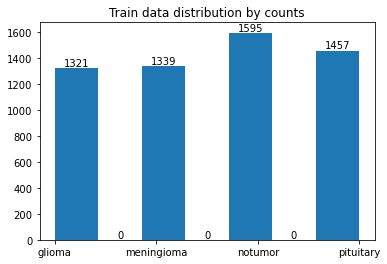

In [6]:
counts, edges, tr_bars = plt.hist(train_labels, bins=7)
plt.title("Train data distribution by counts")
plt.bar_label(tr_bars)
plt.show()

The distribution of the train data is close to uniform distribution. The number of each tumor class' instances are;
* *glioma*: 1321
* *meningioma*: 1339
* *pituitary*: 1457
* *notumor*: 1595

Let's see the percentage of these values on a pie chart:

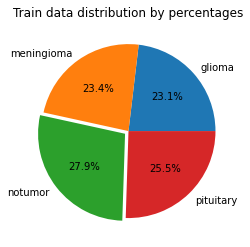

In [7]:
plt.pie(unique_tr_label_counts, labels=unique_tr_labels, 
        explode=[0, 0, 0.05, 0], autopct='%.1f%%')
plt.title("Train data distribution by percentages")
plt.show()

The pie chart shows that 72.1% of the brain images have the brain tumor, and the rest belong to healthy individuals. Let's now make these analyses for the test data:

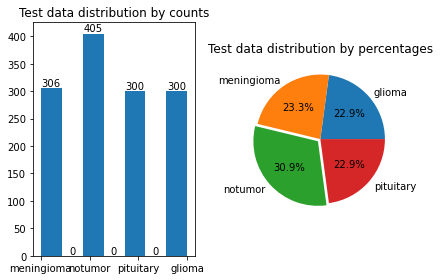

In [8]:
unique_ts_labels, unique_ts_label_counts = np.unique(test_labels, return_counts=True)

fig, (ax1, ax2) = plt.subplots(1, 2)

counts, edges, ts_bars = ax1.hist(test_labels, bins=7)
ax1.set_title("Test data distribution by counts")
ax1.bar_label(ts_bars)

ax2.pie(unique_ts_label_counts, labels=unique_ts_labels, 
        explode=[0, 0, 0.05, 0], autopct='%.1f%%')
ax2.set_title("Test data distribution by percentages")

fig.tight_layout()
plt.show()

In this dataset, there are 7022 images in total and they are split into train and test sets by default. Let's see the percentages of the train and tests:

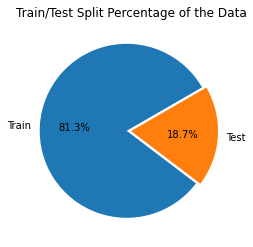

In [9]:
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        autopct='%.1f%%', explode=(0.05,0),
        startangle=30);
plt.title("Train/Test Split Percentage of the Data")
plt.show()

The train/test split is made with a 0.2 ratio which is reasonable for classification tasks.

After understanding the distribution of the data, we can see samples. To do this, we will implement a simple function that returns the images as NumPy arrays given the paths of the images. Since the return type will be NumPy array, we will be able to both manipulate the images, and also view them using Matplotlib's *imshow()* function. We will use images with *128x128* size for faster training so that we will resize it.

In [10]:
IMAGE_SIZE = 128

def get_images(img_paths):
    images = []

    for img_path in img_paths:
        img = load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img = np.array(img)/255 # converts image to NumPy array and normalizes
        images.append(img)
    return np.array(images)

We now have the function to get the images. The function normalizes the images after converting them into NumPy arrays due to the fact that it will be used in the data preparation section as well. Let's try to get some images with their labels! We will display a random image with its label:

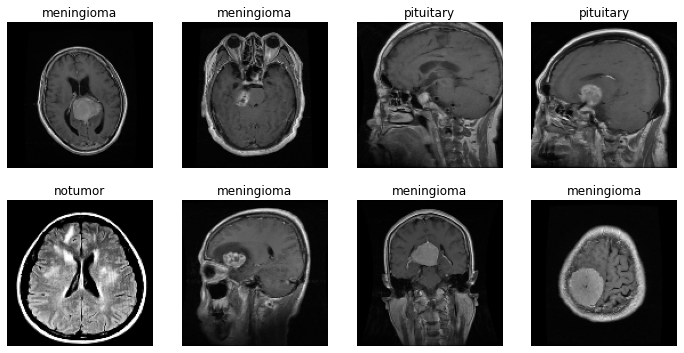

In [11]:
random_img_index = random.randint(0, len(train_paths)-10)
images = get_images(train_paths[random_img_index : random_img_index + 9])
labels = train_labels[random_img_index : random_img_index + 9]

fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])

plt.rcParams.update({'font.size': 12})
plt.show()

## **3 - Data Preparation**

Since the labels of the images are words and we need quantitative data to pass it through the CNN model, we need to convert these values into quantitative versions. Normally, label encoders can be used for this purpose. But in our case, there are 4 different label and we can make the label/number assignment by following:
* *glioma:* 0
* *meningioma:* 1
* *notumor:* 2
* *pituitary:* 3

In [42]:
unique_tr_labels

array(['glioma', 'meningioma', 'notumor', 'pituitary'], dtype='<U10')

We already have the unique label names from the previous sections. An encoder and a decoder function can be created using this list:

In [38]:
def encode_labels(labels):
    encoded_labels = []

    for label in labels:
        encoded_labels.append(unique_tr_labels.index(label))
    
    return np.array(encoded_labels)

def decode_labels(labels):
    decoded_labels = []

    for label in labels:
        decoded_labels.append(unique_tr_labels[label])
    
    return np.array(decoded_labels)

We can encode/decode the labels now. Let's create a function that converts the data we have into a format that can be passed to the CNN model.

This function will be a generator function that gets a batch size and creates a batch for the training process that contains images and encoded labels. But, why do we need it?

The batch size is a number of samples processed before the model is updated. The number of epochs is the number of complete passes through the training dataset. The size of a batch must be $>= 1$ and $<=$ number of samples in the training set.

In [39]:
def data_generator(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = get_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_labels(batch_labels)
            yield batch_images, batch_labels

The function will return two list for images and labels everytime it is called. This capability is coming from the *yield* keyword which makes the function a "generator function". For every call, it will continue from where it left off.

Now, we are ready to create the VGG-16 Convolution Neural Network (CNN).

## **4 - VGG-16 Model**

We have chosen VGG-16 architecture for our classification task due to its short training time and high accuracy compared to other CNN models.

![CNN comparison](https://www.researchgate.net/publication/336061238/figure/tbl3/AS:807363946758156@1569501973797/Classification-accuracy-in-percent-comparison-of-CNN-Based-models.png)
Source: Hang, J., Zhang, D., Chen, P., Zhang, J., & Wang, B. (2019). Classification of plant leaf diseases based on improved convolutional neural network. *Sensors*, 19(19), 4161.


VGG-16 is an object detection and classification algorithm which is able to classify 1000 images of 1000 different categories with 92.7% accuracy. It is one of the most popular algorithms for image classification.

![VGG-16](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)
Source: *VGG16 – Convolutional Network for Classification and Detection*. (2018). Neurohive. https://neurohive.io/en/popular-networks/vgg16/

For the implementation of the model, Keras will be used.

In [26]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')

# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_tr_labels), activation='softmax'))

The model is created using Keras with the correct dimensions needed. We can see the structure of the model as a list of layers.

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_2 (Dropout)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
N

To see the input/output dimensions of each layer, we can use Keras' *plot_model* function:

In [33]:
# To make the below function work:
#!pip install pydot
#!pip install pydotplus
#!pip install graphviz
# Download and install graphviz binaries from: https://graphviz.org/download/
# Add graphviz to PATH (it asks during installation)

keras.utils.plot_model(model, show_shapes=True)

  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24575 sha256=539bca96470fbe4b475a5b6332e8b7b84d9652bcf26ac24e7bdd44631e56f35a
  Stored in directory: c:\users\kerem\appdata\local\pip\cache\wheels\89\e5\de\6966007cf223872eedfbebbe0e074534e72e9128c8fd4b55eb
Successfully built pydotplus
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


We can compile the model now. But before that, we should understand why we have chosen which parameter for what:

* **Loss function:** *sparse_categorical_crossentropy* -> Used as a loss function for multi-class classification model where the output label is assigned integer value (0, 1, 2, 3…).

* **Optimizer:** *Adam* -> It is one of the most popular optimizers that is a replacement optimization algorithm for stochastic gradient descent for training deep learning models. Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems.

* **Metric:** *sparse_categorical_accuracy* -> Checks to see if the maximal true value is equal to the index of the maximal predicted value

In [36]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

## **5 - Train Model**

We can train our model now. Below are the some of the hyperparameters that are used to train our model. We are going to change the values of these hyperparameters to catch the best accurate model. (Hyperparameter - Tuning)

* **Batch Size:**  It is a term used in machine learning and refers to the number of training examples utilized in one iteration

* **Epochs:** An epoch is when all the training data is used at once and is defined as the total number of iterations of all the training data in one cycle for training the machine learning model. Another way to define an epoch is the number of passes a training dataset takes around an algorithm.

* **Steps Per Epoch:** (Total Number of Training Samples) / (Batch Size)



In [40]:
# Hyper parameters
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 4

history = model.fit(data_generator(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

AttributeError: 'numpy.ndarray' object has no attribute 'index'

Lets see the total loss and sparse_categorical_accuracy values per epoch on a chart.

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## **5 - Evaluate the Model with Test Samples**

In this step, we will evaluate the model performance in terms of precision, recall and f1-score. The dataset we will use to measure the performance of our model is going to be unseen by model, which is test dataset.

* **Precision:**  Precision is a metric used to evaluate the performance of a classifier or predictor in a binary classification problem. It is defined as the proportion of true positive predictions made by the classifier. In other words, it measures the ability of the classifier to accurately predict positive cases.

* **Recall:** Recall is a metric used to evaluate the performance of a classifier or predictor in a binary classification problem. It is defined as the proportion of positive cases that were correctly identified by the classifier. In other words, it measures the ability of the classifier to identify all positive cases in the dataset.

* **F1-Score:** The F1 score is a metric used to evaluate the performance of a classifier or predictor in a binary classification problem. It is defined as the harmonic mean of precision and recall, where precision is the proportion of true positive predictions made by the classifier, and recall is the proportion of positive cases that were correctly identified by the classifier. The F1 score ranges from 0 to 1, with a higher value indicating better performance. The F1 score is often used as a way to balance precision and recall, as it considers both measures equally.

In [41]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(data_generator(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/40 [00:00<?, ?it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'index'

Here is the classification report where all these evaluation metrics are shown for each label

In [ ]:
print(classification_report(y_true, y_pred))